# opis problemu

**Opis danych:** "The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations."

**Lokalizacja danych:** Dane znajdują się na dysku Google tutaj: [flights.csv](https://drive.google.com/file/d/1ryE8mPQlommi88PaeiRSGQJOn4OYte64/view?usp=sharing).


 ## "Should I stay, or should I go"
 
Problem wziął się z pomysłu na aplikację mobilną która wskazuje czy wybrany lot odleci o czasiem czy spóźni się o więcej niż 60'. Aplikacja będzie bardzo użyteczna - jeśli lot ma się opóźnić nie warto wyjeżdzać na lotnisko za wcześnie.

---
Zadanie: skonstruować model uczenia maszytnowego, który przyjume dane o locie, i zwraca informację: 

**Czy lot opóżni się o więcej niż 60'?**  - TAK/NIE

Plan pracy:
  
1) użycie nasdępujących modeli:

    * regresja logistyczna
    * naiwny klasyfikator Bayesa
    * drzewa decyzyjne
    * maszyna wektorów nośnych

2) znalezienie kolumny silnie skorelowaną z etykietą (odpowiedzią na pytanie zadane modelowi).

3) sprawdzenie metryk modeli na zbiorze uczącym i testowym i wskazanie modelu który jest najlepszy.

4) pytanie kontrolne: 

**Model stwierdził, że lot opóźni się o więcej niż 60' - użytkownik modelu wyszedł później na lotnisko. 
  Jakie jest prawdopodobieństwo, że w tej sytuacji lot jednak był o czasie (i użytkownik pewnie się na niego spóźnił)?**
  


---  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




**Wstępna obróbka danych**: dane zawierają kolumny numeryczne, oraz z napisami, np. kod lotnisk "JFK", oraz wiersze gdzie niektóre kolumny są puste. Przed analizą należy:

* usunąć kolumny dla których zwykle nie ma żadnej informacji
* stworzyć kolumnę etykiet zawierającą wartości **0** lub **1** zależnie od tego czy opóźnenie było większe niż 60'
* zamienić napisy na wartości liczbowe korzystając z metody ```Pandas.factorize(...)```:
    
    ```
    df[column] =  pd.factorize(df[column])[0]
    ```
    
* niektóre wiersze mogą nadal zawierać nieokreślone wartości - ```NaN``` - należy je usunąć  
* danych jest bardzo dużo - by przyspieszyć obliczenia do treningu proszę użyć odpowiednio małej części
---
---

# <center>Rozwiązanie</center>


## wstęp

Imformacja wstępna: 

początkowo rozwiązano problem nie wyrównując w żaden sposób zbiorów danych. Dla regresji liniowej otrzymano następującą ocenę jakości modelu:


---



**Accuracy:  0.9411021814006889**

Classification report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16394
           1       0.00      0.00      0.00      1026

    accuracy                           0.94     17420
    macro avg       0.47      0.50      0.48     17420
    weighted avg       0.89      0.94      0.91     17420

Macierz błędów

* TN:  16394    
* FP:  0    
* FN:  1026   
* TP:  0

---

Tak wysoka dokładność wynika z tego, że spóźnienia to ok 5% całości

To pozwala modelowi na bardzo dużą dokładność:

uznanie że lot się nie spóźni daje w 95% trafną odpowiedź




## importy i funkcje

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(21,10)

import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.svm import LinearSVC

In [ ]:
def ocena_jakosci(model,X_test,y_test):
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test,y_pred) # dokładność
    print('Accuracy: ',acc)
    print("Classification report:") # wypisz raport klasyfikacji 
    print(classification_report(y_test,y_pred))

    print("Macierz błędów") # wypisz macierz (confusion matrix)
    print(confusion_matrix(y_test,y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )
    return y_pred

In [ ]:
def rysuj_roc(y_test,y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,'m', label ='roc curve')
    plt.plot([0, 1], [0, 1], 'c--')

    plt.text(0.05, 0.8,'AUC = '+str(round(roc_auc,3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend()

    plt.show()

## przygotowanie danych

In [ ]:
DF = pd.read_csv (r'/content/drive/MyDrive/flights.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tworzę kolumnę etykiet zawierającą wartości 0 lub 1 zależnie od tego czy opóźnenie było większe niż 60'

In [ ]:
DF['LABEL'] = (DF['DEPARTURE_DELAY']>=60)*1

### imbalanced datasets

inspiracja: https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb




In [ ]:
#df = DF.sample(frac=0.04)



aby oszczędzać pamięć biorę 4% danych czyli ok 240 tys lotów:

120 tys opóźnionych i 120 tys na czas

In [ ]:
n=120000 

#wyciągam próbkę z późnionychg lotów
delayed_df = DF.loc[DF['LABEL']==1].sample(n, random_state=4)

#wyciągam próbkę lotów na czas
on_time_df = DF.loc[DF['LABEL']==0].sample(n, random_state=8)

#spinam obia zbiory
df = pd.concat([delayed_df,on_time_df])

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,LABEL
3816920,2015,8,25,2,WN,467,N655WN,HOU,ATL,1400,1516.0,76.0,9.0,1525.0,120.0,120.0,99.0,696,1804.0,12.0,1700,1816.0,76.0,0,0,NaN,0.0,0.0,0.0,0.0,76.0,1
5384145,2015,12,3,4,UA,1977,N75429,IAH,SEA,1755,1936.0,101.0,19.0,1955.0,295.0,311.0,246.0,1874,2201.0,46.0,2050,2247.0,117.0,0,0,NaN,16.0,0.0,0.0,101.0,0.0,1
940802,2015,3,3,2,OO,5449,N920SW,DEN,RKS,1525,1752.0,147.0,20.0,1812.0,74.0,69.0,44.0,260,1856.0,5.0,1639,1901.0,142.0,0,0,NaN,0.0,0.0,0.0,142.0,0.0,1
2579240,2015,6,12,5,OO,4452,N442SW,DAY,MSP,1330,1612.0,162.0,13.0,1625.0,115.0,106.0,89.0,574,1654.0,4.0,1425,1658.0,153.0,0,0,NaN,0.0,0.0,130.0,23.0,0.0,1
5705277,2015,12,24,4,WN,3242,N925WN,DCA,CMH,1135,1555.0,260.0,21.0,1616.0,80.0,83.0,57.0,323,1713.0,5.0,1255,1718.0,263.0,0,0,NaN,3.0,0.0,3.0,257.0,0.0,1


### obróbka po kolumnach

In [ ]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'LABEL'],
      dtype='object')

usuwam kolumny:
* dla których nie ma zwykle żadnej informacji 
* zawierające informacje, których użytkownik nie może podać

In [ ]:
#df['DATE']=pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df=df.drop(['DEPARTURE_TIME','DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',
       'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)

#usuwam wiersze, które nadal zawierają nieokreślone wartości - NaN 
df=df.dropna()

zmieniam napisy na wartości liczbowe

In [ ]:
for column in ['AIRLINE','TAIL_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT']:
    df[column] =  pd.factorize(df[column])[0]


## podgląd danych

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,LABEL
3816920,2015,8,25,2,0,467,0,0,0,1400,120.0,696,1700,1
5384145,2015,12,3,4,1,1977,1,1,1,1755,295.0,1874,2050,1
940802,2015,3,3,2,2,5449,2,2,2,1525,74.0,260,1639,1
2579240,2015,6,12,5,2,4452,3,3,3,1330,115.0,574,1425,1
5705277,2015,12,24,4,0,3242,4,4,4,1135,80.0,323,1255,1


## korelacja

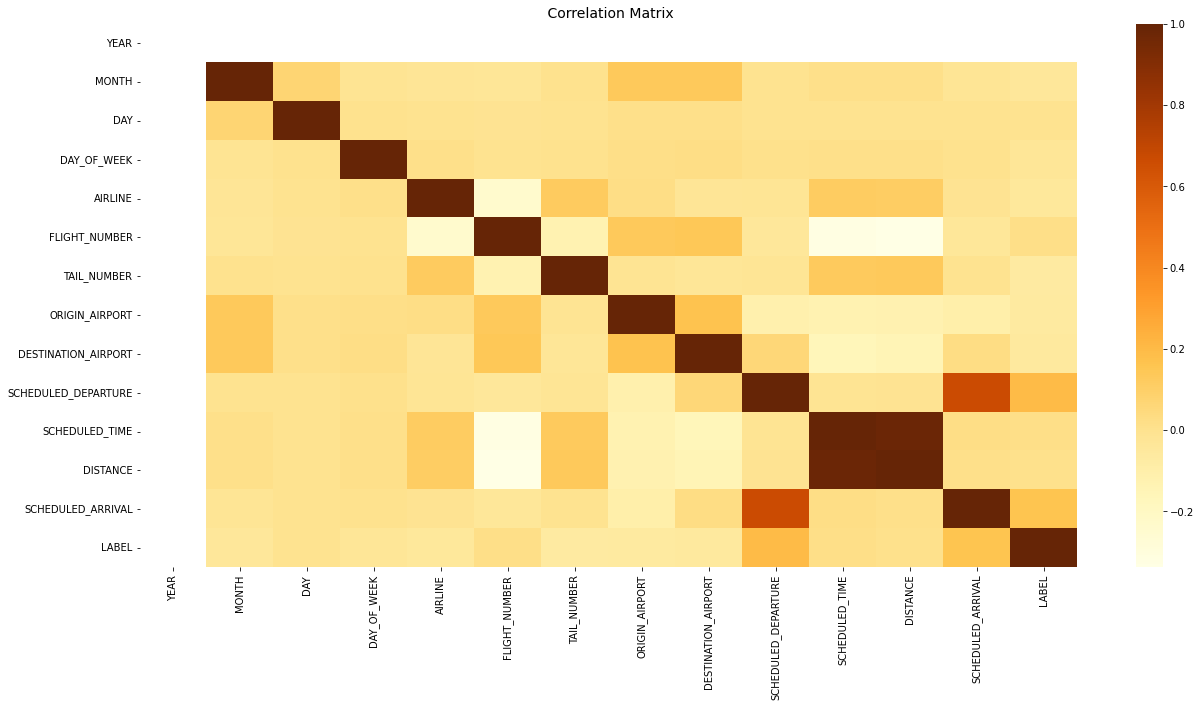

In [ ]:
fig, ax = plt.subplots()         

corr = df.corr()
sns.heatmap(corr, cmap='YlOrBr', annot_kws={'size':2}, ax=ax)
ax.set_title(" Correlation Matrix", fontsize=14)
plt.show()

Po usunięciu kolumn z informacjami, któych użytkownik nie mógłby podać modelowi nie można wskazać cechy silnie skorelowanej z etykietą  

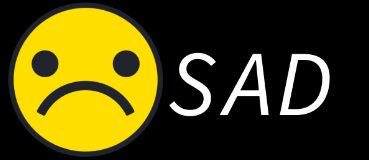



## podział danych i normalizacja

każdy model będzie trenowany i tesowany na tych samych danych

In [ ]:
X = df.drop(['LABEL'],axis=1)
y = df.LABEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

normalizacja

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X_train_mn_mx = min_max_scaler.fit_transform(X_train)

X_test_mn_mx = min_max_scaler.transform(X_test)

## regresja logistyczna

In [ ]:
lr = LogisticRegression(max_iter=10000)
y_train=y_train.ravel()
lr.fit(X_train_mn_mx,y_train)

LogisticRegression(max_iter=10000)

In [ ]:
y_pred=ocena_jakosci(lr,X_test_mn_mx, y_test)

Accuracy:  0.5975494422964591
Classification report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     35634
           1       0.60      0.62      0.61     36268

    accuracy                           0.60     71902
   macro avg       0.60      0.60      0.60     71902
weighted avg       0.60      0.60      0.60     71902

Macierz błędów
[[20623 15011]
 [13926 22342]]
TN:  20623 FP:  15011 FN:  13926 TP:  22342


### krzywa ROC

In [ ]:
#rysuj_roc(y_test,y_pred)

## naiwny klasyfikator Bayesa

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_mn_mx,y_train)

MultinomialNB()

In [ ]:
y_pred=ocena_jakosci(clf,X_test_mn_mx, y_test)

Accuracy:  0.5884815443242191
Classification report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59     35634
           1       0.59      0.59      0.59     36268

    accuracy                           0.59     71902
   macro avg       0.59      0.59      0.59     71902
weighted avg       0.59      0.59      0.59     71902

Macierz błędów
[[20893 14741]
 [14848 21420]]
TN:  20893 FP:  14741 FN:  14848 TP:  21420


## drzewo decyzyjne 

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(X_train_mn_mx, y_train)

In [ ]:
y_pred = ocena_jakosci(clf,X_test_mn_mx, y_test)

Accuracy:  0.6234318934104753
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61     35634
           1       0.62      0.65      0.64     36268

    accuracy                           0.62     71902
   macro avg       0.62      0.62      0.62     71902
weighted avg       0.62      0.62      0.62     71902

Macierz błędów
[[21183 14451]
 [12625 23643]]
TN:  21183 FP:  14451 FN:  12625 TP:  23643


* wizualizacja

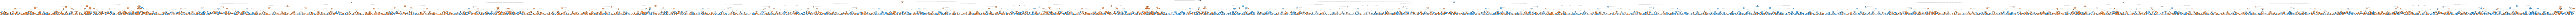

In [ ]:
from IPython.display import Image  
from six import StringIO
import pydot 

dot_data = StringIO()  

tree.export_graphviz(clf, out_file=dot_data, feature_names=df.columns[:-1],  
                        class_names=df.columns[-1],  
                        filled=True, rounded=True,  
                        special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## SVC

In [ ]:
SVC = LinearSVC(dual = False, max_iter = 4000)
SVC.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=4000)

In [ ]:
y_pred = ocena_jakosci(SVC,X_test_mn_mx, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


Accuracy:  0.49588328558315486
Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     35634
           1       0.53      0.00      0.01     36268

    accuracy                           0.50     71902
   macro avg       0.51      0.50      0.34     71902
weighted avg       0.51      0.50      0.33     71902

Macierz błędów
[[35482   152]
 [36095   173]]
TN:  35482 FP:  152 FN:  36095 TP:  173


# podsumowanie

## problemy :

2) znalezienie kolumny silnie skorelowaną z etykietą (odpowiedzią na pytanie zadane modelowi).

3) sprawdzenie metryk modeli na zbiorze uczącym i testowym i wskazanie modelu który jest najlepszy.

4) pytanie kontrolne: 

**Model stwierdził, że lot opóźni się o więcej niż 60' - użytkownik modelu wyszedł później na lotnisko. 
  Jakie jest prawdopodobieństwo, że w tej sytuacji lot jednak był o czasie (i użytkownik pewnie się na niego spóźnił)?**

## odpowiedzi:

* ad.2 

nie jest możliwe wskazanie takiej kolumny pośród, tych które użytkownik mógłby samodzielnie uzupełnić

* ad. 3 

Najlepiej działającym modelem okazało się drzewo decyzyjne, ale nawet tutaj wyniki nie były zachwycające - z ACC na poziomie 0.62. 

Mimo wszystko jest to najbardziej obiecujący model, szczególnie biorąc pod uwagę fakt że można jeszcze popracować nad jego regulacją

Regresja liniowa oraz bayes dały podobne wyniki ACC ok 0.59

SVM jest najmniej wydajnym modelem - długo się "mieli" i daje najgorsze wyniki - ACC ok 0.5

* ad.4 

Z takimi wynikami to prawdopodobieństwo jest bardzo duże, żadnemu z modeli nie można ufać

